# Gridsearch SARIMA
- ***Darlene Adams***

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.ticker as mticks
import pmdarima as pm

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn import set_config

from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs

import statsmodels.tsa.api as tsa
import itertools

plt.rcParams['figure.figsize']=(12,3)

import warnings
warnings.filterwarnings("ignore")

In [2]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None,
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)

    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index,
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();

    return fig, ax

In [3]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d,
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags,
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [4]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5),
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},
                  annotate_seas=False, m = None,
                 seas_color='black', method = 'ywm'):

    fig, axes = plt.subplots(nrows=2, figsize=figsize)
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')
    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )
    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    # Annotate sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)
    # seasons
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        # Calculate number of complete seasons to annotate
        n_seasons = nlags//m

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)

        # for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()

    return fig

In [5]:
def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [6]:
def millions(x,pos):
    """function for use wth matplotlib FuncFormatter -  formats money in millions"""
    new_x = x/1_000_000
    return f"{new_x:,.0f}M"
def thousands(x,pos):
    """function for use wth matplotlib FuncFormatter -  formats money in millions"""
    new_x = x/1_000
    return f"{new_x:,.0f}K"
# Create the formatters
fmt_mill = mticks.FuncFormatter(millions)
fmt_thous = mticks.FuncFormatter(thousands)

In [7]:
fmt_mill = mticks.FuncFormatter(millions)
fmt_thous = mticks.FuncFormatter(thousands)

In [16]:
fpath = "https://docs.google.com/spreadsheets/d/e/2PACX-1vQN3Ksa9szQuO4G1-msXWAp17KtVHQCBnuEieu_auu1wSiBf3-krHusIx5VBMkihxj-KZLBosDIGEyR/pub?output=csv"
df = pd.read_csv(fpath)
df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0,255517.0,...,741586.0,745686.0,750578.0,756734.0,762321.0,768797.0,773944.0,777692.0,779960.0,781622.0
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,234181.0,234401.0,...,924019.0,928991.0,937936.0,953874.0,973168.0,990391.0,992337.0,992630.0,978196.0,966595.0
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,109068.0,109079.0,...,245783.0,248718.0,252080.0,256435.0,261101.0,265558.0,268901.0,271059.0,272400.0,272639.0
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,166139.0,166536.0,...,302821.0,305104.0,306404.0,308303.0,309649.0,312487.0,314663.0,315910.0,315587.0,315429.0
4,6915,4,San Antonio,city,TX,TX,"San Antonio-New Braunfels, TX",Bexar County,114794.0,114975.0,...,269323.0,274032.0,278464.0,284127.0,289739.0,294776.0,297727.0,298796.0,299124.0,298951.0


In [17]:
NY= df['SizeRank'] < 1
NY

0         True
1        False
2        False
3        False
4        False
         ...  
22462    False
22463    False
22464    False
22465    False
22466    False
Name: SizeRank, Length: 22467, dtype: bool

In [18]:
ts= df[NY]
ts.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0,255517.0,...,741586.0,745686.0,750578.0,756734.0,762321.0,768797.0,773944.0,777692.0,779960.0,781622.0


In [19]:
ts.columns

Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'Metro', 'CountyName', '2000-01-31', '2000-02-29',
       ...
       '2021-12-31', '2022-01-31', '2022-02-28', '2022-03-31', '2022-04-30',
       '2022-05-31', '2022-06-30', '2022-07-31', '2022-08-31', '2022-09-30'],
      dtype='object', length=281)

In [20]:
melted = pd.melt(ts.drop(columns=['RegionID','RegionType','StateName','SizeRank',
                            'State', 'Metro','CountyName']),
           id_vars=['RegionName'], var_name='Date')
melted

,RegionName,Date,value
0,New York,2000-01-31,253690.0
1,New York,2000-02-29,255517.0
2,New York,2000-03-31,257207.0
3,New York,2000-04-30,260310.0
4,New York,2000-05-31,263204.0
...,...,...,...
268,New York,2022-05-31,768797.0
269,New York,2022-06-30,773944.0
270,New York,2022-07-31,777692.0
271,New York,2022-08-31,779960.0


In [21]:
melted['Date'] = pd.to_datetime(melted['Date'])
melted['Date']

0     2000-01-31
1     2000-02-29
2     2000-03-31
3     2000-04-30
4     2000-05-31
         ...    
268   2022-05-31
269   2022-06-30
270   2022-07-31
271   2022-08-31
272   2022-09-30
Name: Date, Length: 273, dtype: datetime64[ns]

In [22]:
ts = melted.set_index('Date')
ts.index
ts.head()

,RegionName,value
Date,,
2000-01-31,New York,253690.0
2000-02-29,New York,255517.0
2000-03-31,New York,257207.0
2000-04-30,New York,260310.0
2000-05-31,New York,263204.0


In [23]:
ts.isnull().sum()

RegionName    0
value         1
dtype: int64

In [24]:
ts = ts.ffill()
ts.isna().sum()

RegionName    0
value         0
dtype: int64

In [25]:
ts.info

<bound method DataFrame.info of            RegionName     value
Date                           
2000-01-31   New York  253690.0
2000-02-29   New York  255517.0
2000-03-31   New York  257207.0
2000-04-30   New York  260310.0
2000-05-31   New York  263204.0
...               ...       ...
2022-05-31   New York  768797.0
2022-06-30   New York  773944.0
2022-07-31   New York  777692.0
2022-08-31   New York  779960.0
2022-09-30   New York  781622.0

[273 rows x 2 columns]>

In [26]:
ts1 = ts.drop(columns='RegionName')
ts1.columns

Index(['value'], dtype='object')

In [27]:
ts1= ts1.resample('M').sum()

## Filter for data that starts 2018 

In [31]:
ts_ny = ts1.loc['2018':'2023']
ts_ny

,value
Date,
2018-01-31,656700.0
2018-02-28,661012.0
2018-03-31,665672.0
2018-04-30,669989.0
2018-05-31,673514.0
2018-06-30,676434.0
2018-07-31,678984.0
2018-08-31,681140.0
2018-09-30,683546.0


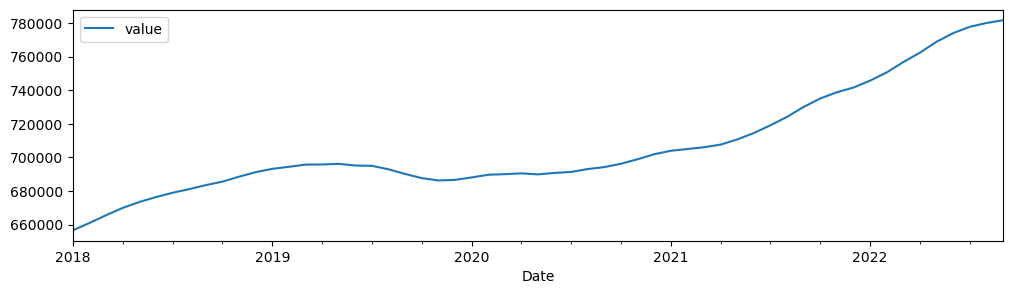

In [32]:
# Visualize the time series
ts_ny.plot();

## Check Seasonality

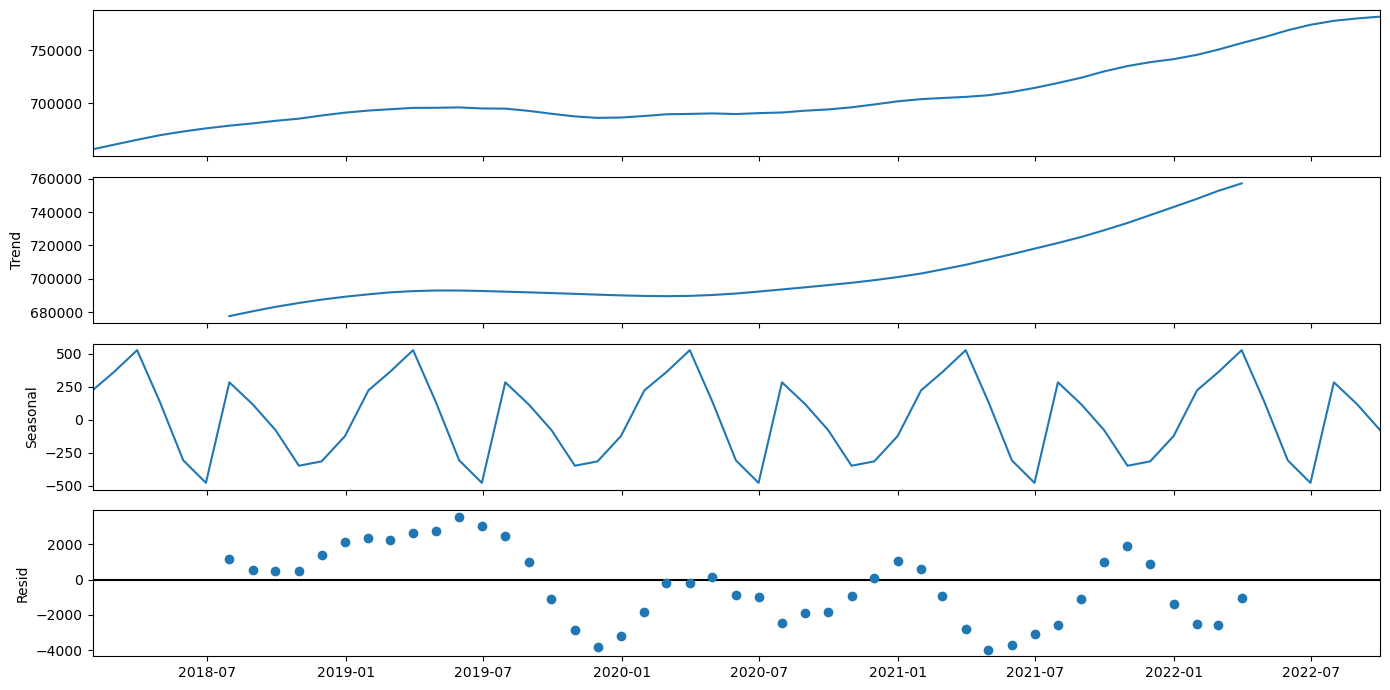

In [34]:
# Seasonal decomposition
decomp = tsa.seasonal_decompose(ts_ny)
fig = decomp.plot()
fig.set_size_inches(14,7)
fig.tight_layout()

In [36]:
# How big is the seasonal component
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min()
seasonal_delta

1006.1319444442925

In [37]:
ts_ny.min()

value    656700.0
dtype: float64

In [38]:
ts_ny.max()

value    781622.0
dtype: float64

In [39]:
NY_max = 781622.0
NY_min = 656700.0
perc = seasonal_delta/(NY_max-NY_min) * 100

In [40]:
# How big is the seasonal component relative to the time series?
print(f"The seasonal component is {seasonal_delta} which is ~{perc:.2f}% of the variation in time series.")

The seasonal component is 1006.1319444442925 which is ~0.81% of the variation in time series.


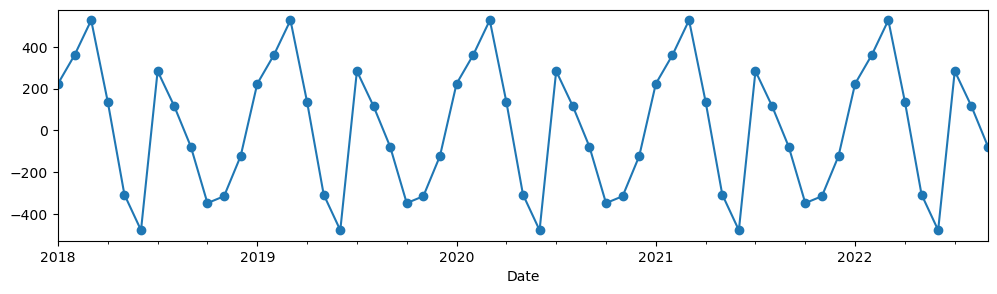

In [41]:
seasonal = decomp.seasonal
ax = seasonal.plot(marker = 'o')

In [42]:
# Check for stationarity
get_adfuller_results(ts_ny)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,0.407572,4,52,0.981776,0.05,False


In [43]:
d = ndiffs(ts_ny)
print (f'd = {d}')
# determine D
D = nsdiffs(ts_ny, m = 12)
print (f'D = {D}')

d = 2
D = 0


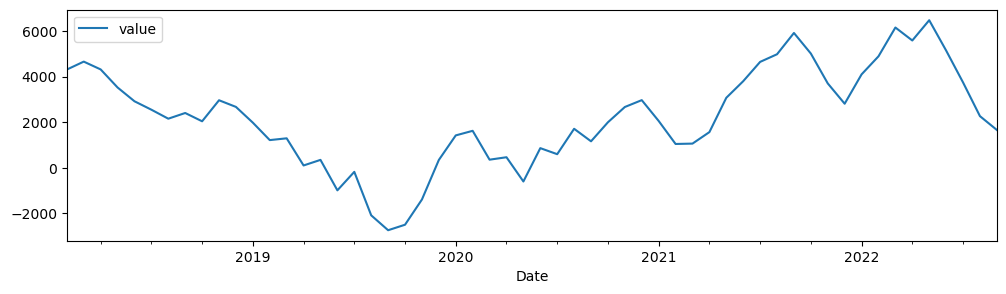

In [127]:
# apply differencing
NY_diff = ts_ny.diff().dropna()
NY_diff.plot();

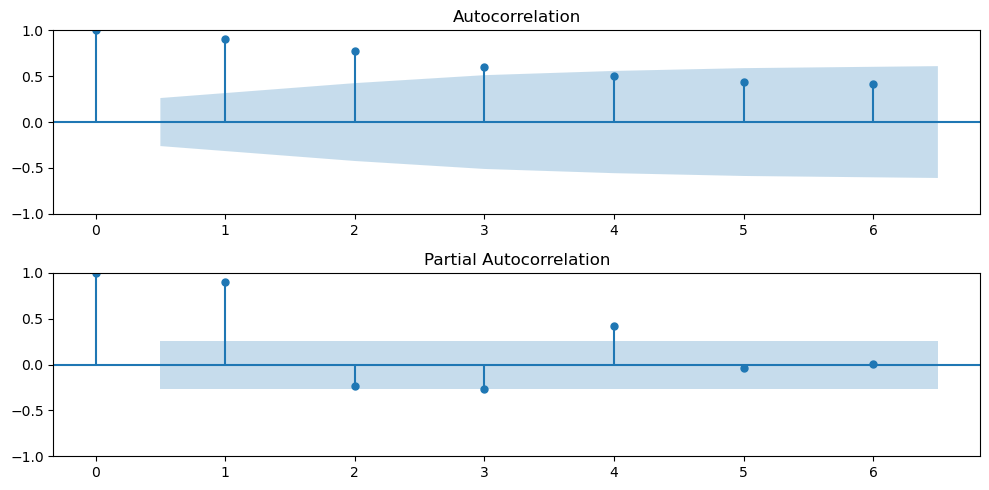

In [128]:
# Check the acf/pacf of the stationary data
plot_acf_pacf(NY_diff, annotate_seas = True, m = 12, nlags = 6);

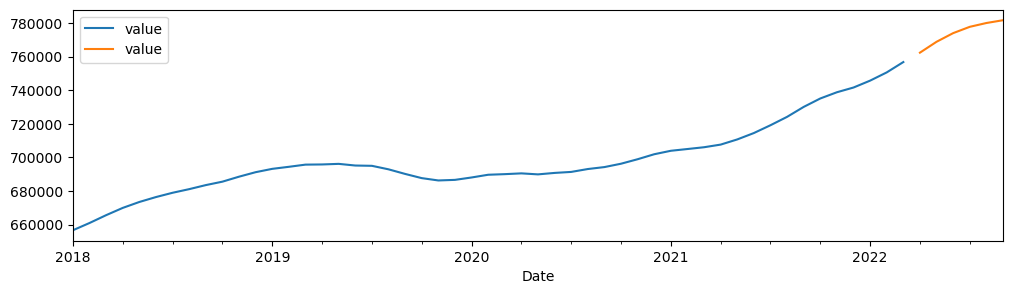

In [130]:
# train test split
train, test = train_test_split(ts_ny, test_size=.10)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

In [131]:
# Orders for non seasonal components
p = 0  # nonseasonal AR
d = 2  # nonseasonal differencing
q = 0  # nonseasonal MA
# Orders for seasonal components
P = 0  # Seasonal AR
D = 0  # Seasonal differencing
Q = 0  # Seasonal MA
m = 12 # Seasonal period

sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Obtain summary
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   51
Model:                 ARIMA(0, 2, 0)   Log Likelihood                -402.263
Date:                Fri, 08 Dec 2023   AIC                            806.526
Time:                        11:25:14   BIC                            808.418
Sample:                    01-31-2018   HQIC                           807.244
                         - 03-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7.899e+05   2.22e+05      3.550      0.000    3.54e+05    1.23e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.22   Jarque-Bera (JB):                 1.94
Prob(Q):                              0.27   Prob(JB):                         0.38
Heteroskedasticity (H):               1.99   Skew:                            -0.05
Prob(H) (two-sided):                  0.18   Kurtosis:                         2.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

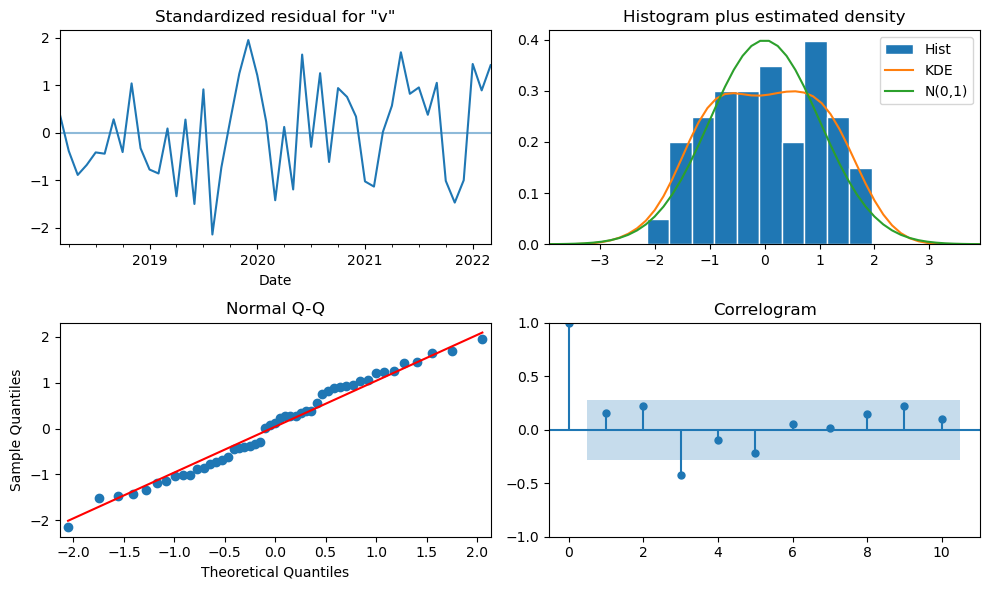

In [132]:
# Obtain diagnostic plots
fig = sarima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 4,224.000
- MSE = 36,270,850.333
- RMSE = 6,022.529
- R^2 = 0.196
- MAPE = 0.54%


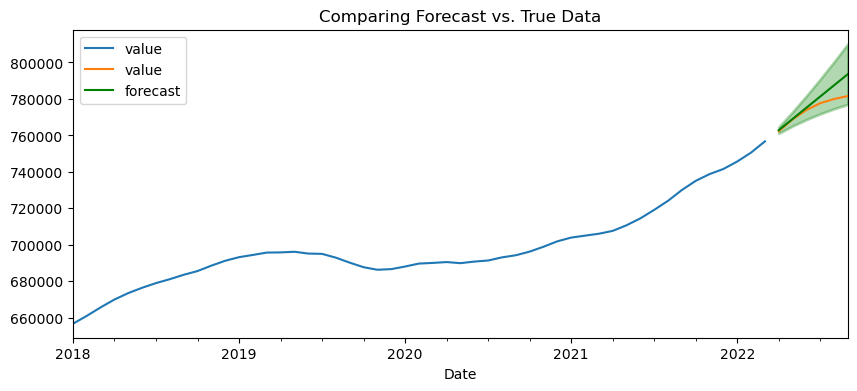

In [133]:
forecast_df = sarima.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df);
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

In [134]:
# Default auto_arima will select model based on AIC score
auto_model = pm.auto_arima(
    train,
    seasonal=True,
    m=12,
    trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1040.347, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=909.717, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=930.102, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=912.587, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=940.569, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=911.717, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=911.717, Time=0.02 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=913.717, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=928.324, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=910.593, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=907.207, Time=0.13 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=909.209, Time=0.29 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=1024.876, Time=0.13 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=911.335, Time=0.34 sec
 ARIMA(2,1,1)(0,0,0)[12] interc

In [135]:
print(auto_model.order)
print(auto_model.seasonal_order)

(1, 1, 1)
(0, 0, 0, 12)


In [136]:
# Obtain summary of the best model from auto_arima
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   51
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -449.603
Date:                Fri, 08 Dec 2023   AIC                            907.207
Time:                        11:25:49   BIC                            914.855
Sample:                    01-31-2018   HQIC                           910.119
                         - 03-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    593.8235   1281.381      0.463      0.643   -1917.637    3105.283
ar.L1          0.6749      0.693      0.974      0.330      -0.683       2.032
ma.L1         -0.6674      0.694     -0.962      0.336      -2.028       0.693
sigma2      3.622e+06      0.252   1.44e+07      0.000    3.62e+06    3.62e+06
===================================================================================
Ljung-Box (L1) (Q):                  37.34   Jarque-Bera (JB):                 0.01
Prob(Q):                              0.00   Prob(JB):                         0.99
Heteroskedasticity (H):               4.84   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.08e+24. Standard errors may be unstable.
"""

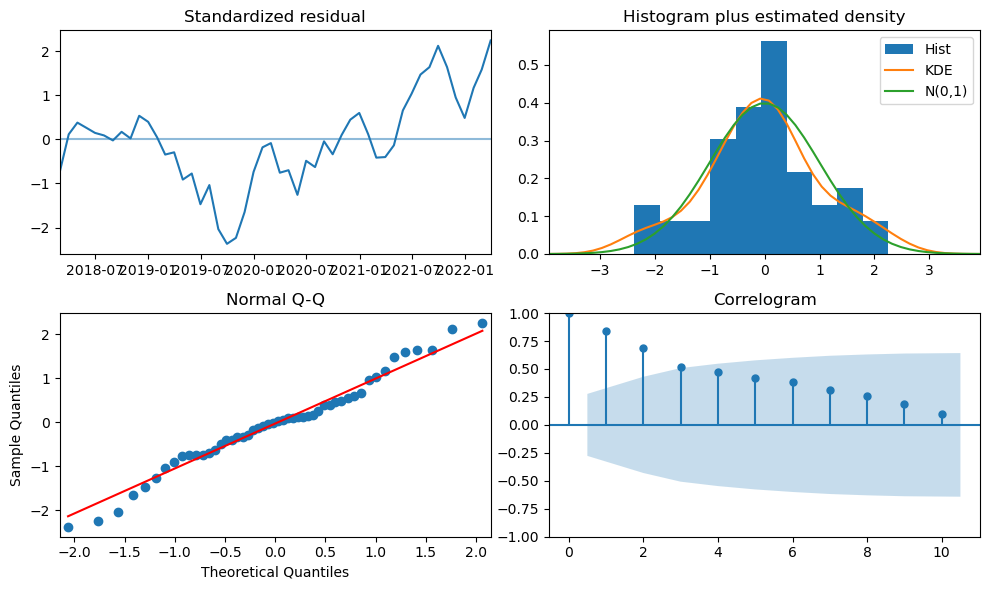

In [137]:
# Obtain diagnostic plots
fig = auto_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 10,336.391
- MSE = 119,088,166.132
- RMSE = 10,912.752
- R^2 = -1.640
- MAPE = 1.33%


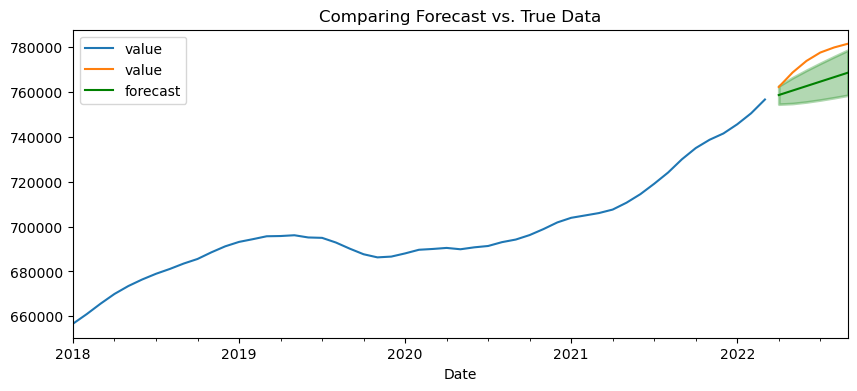

In [138]:
auto_model = tsa.ARIMA(
    train, order=auto_model.order, seasonal_order=auto_model.seasonal_order
).fit()


# Obtain forecast as a dataframe with confidence intervals
forecast_df = auto_model.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df);
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

In [139]:
# These are the parameters of our final model
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 1  # nonseasonal MA

# Orders for seasonal components
P = 0  # Seasonal AR
D = 0  # Seasonal differencing
Q = 0  # Seasonal MA
m = 12 # Seasonal period

final_model = tsa.ARIMA(ts_ny, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

In [140]:
len(test)

6

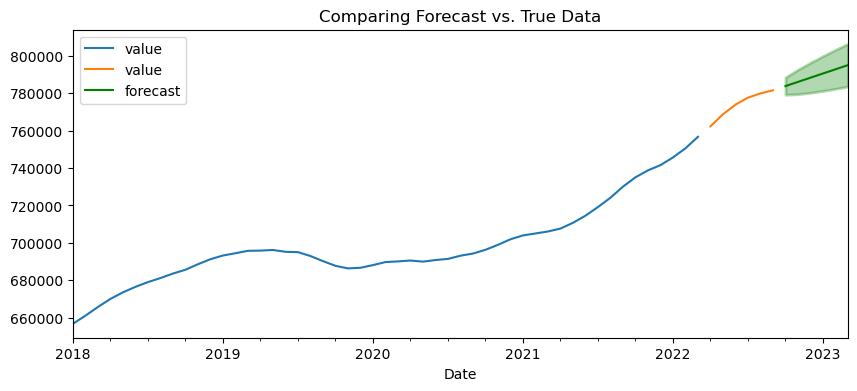

In [141]:
# future forecasts
forecast_df  = final_model.get_forecast(len(test)).summary_frame()
plot_forecast(train,test,forecast_df);

In [142]:
forecast_df.index[0],forecast_df.index[-1]

(Timestamp('2022-10-31 00:00:00', freq='M'),
 Timestamp('2023-03-31 00:00:00', freq='M'))

In [143]:
starting_value = forecast_df['mean'].iloc[0]
starting_value

783869.4233004089

In [144]:
final_value = forecast_df['mean'].iloc[-1]
final_value

795106.5087287362

In [145]:
change = final_value - starting_value
change

11237.085428327322

In [146]:
perc_change = (change / starting_value) * 100
perc_change

1.4335404717044102

## Questions:
What is the predicted home value in New York City 6 months into the future (beyond the dataset)?
- $795,106.51

What is the percent change in home values in New York City by the end of the 6-month forecast (beyond the dataset)?
- -2.5%